In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
from skimage.color import rgb2gray

In [ ]:
video = cv2.VideoCapture('LipoKDEL1ug_biotin_no drug_live_5min1h.avi')
fps = video.get(cv2.CAP_PROP_FPS)
print('frames per second =',fps)

# seconds = 0.0857142857
# frame_id = int(fps*(60 + seconds))
# print('frame id =',frame_id)

In [ ]:
seconds = 0.0857142857
frame_id = int(fps*(seconds))
print('frame id =',frame_id)

In [ ]:
video.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
ret, frame = video.read()

In [ ]:
cv2.imshow('frame', frame); cv2.waitKey(0)
cv2.imwrite('LipoKDEL1ug_biotin_no drug_live_5min1h.png', frame)

In [ ]:
#Definitely need to change this. Just used this to get over the initial hurdle
def extract_frames(video_path, frame_rate=12, output_dir="frames"):
  """Extracts frames from a video file and saves them with unique names.

  Args:
    video_path: The path to the video file.
    frame_rate: The desired frame rate for the extracted frames.
    output_dir: The directory to save the extracted frames.

  Returns:
    A list of extracted frames.
  """

  cap = cv2.VideoCapture(video_path)

  frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frame_interval = frame_count // frame_rate

  frames = []
  for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
      break
    if i % frame_interval == 0:
      frames.append(frame)

  # Create the output directory if it doesn't exist
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)

  # Save the extracted frames with unique names
  for i, frame in enumerate(frames, start = 1):
    filename = f"LipoKDEL1ug_biotin_no drug_live_5min1h_frame_{i:02d}.jpg"  # Use 2-digit padding for filenames
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, frame)

  return frames

# Extract frames from the video file
current_directory = os.getcwd()
video_path = os.path.join(current_directory, "LipoKDEL1ug_biotin_drug25uM_live_5min1h.avi")
frames = extract_frames(video_path)

print(f"Extracted {len(frames)-1} frames.")

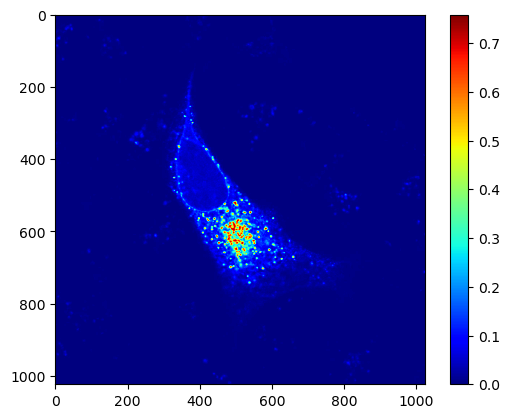

In [38]:
img_data = plt.imread('LipoKDEL1ug_biotin_no drug_live_5min1h_frame_01.jpg') #importing the first frame
img_gray = rgb2gray(img_data) #converting to grayscale
plt.imshow(img_gray, cmap='jet')
plt.colorbar()

type(img_data)=<class 'numpy.ndarray'>
img_data.shape=(3145728,)
img_data.min()=0
img_data.max()=255
img_data.sum()=4578101


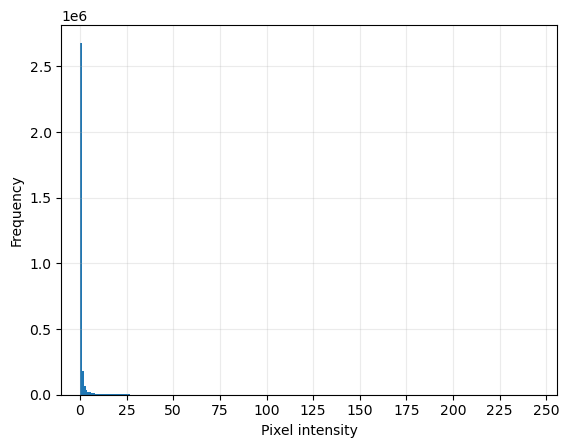

In [54]:
print(f'{type(img_data)=}', 
      f'{img_data.shape=}', #dimension of image, looks damn wonky.
      f'{img_data.min()=}', #tells us the dimmest pixel, 0, background noise
      f'{img_data.max()=}', #brightest pixel value, 255 as we converted to gray_scale
      f'{img_data.sum()=}', #sums all the overall brightness of pixels in the image
      sep='\n')

img_data = img_data.flatten() #converting it to 1d array
plt.hist(img_data, bins = 256) #uint8 range is 0-255
plt.xlim(-10, 256) #change so can observe those at 0 better

ticks = [i for i in range(0, 256, 25)] #using list comprehension, start 0, end 256 in intervals of 25

plt.xticks(ticks) #setting x intervals
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.grid(alpha = 0.25)
plt.show()

In [42]:
total_fluorescence = []

for i in range(1, 13+1):
    img = io.imread(f'LipoKDEL1ug_biotin_no drug_live_5min1h_frame_{i:02}.jpg')
    total_fluorescence.append(img.sum())

print(total_fluorescence)

[4578101, 5465947, 4992879, 4265734, 3501425, 3121450, 3545833, 3263858, 2894751, 2952973, 2785513, 2340890, 2263633]


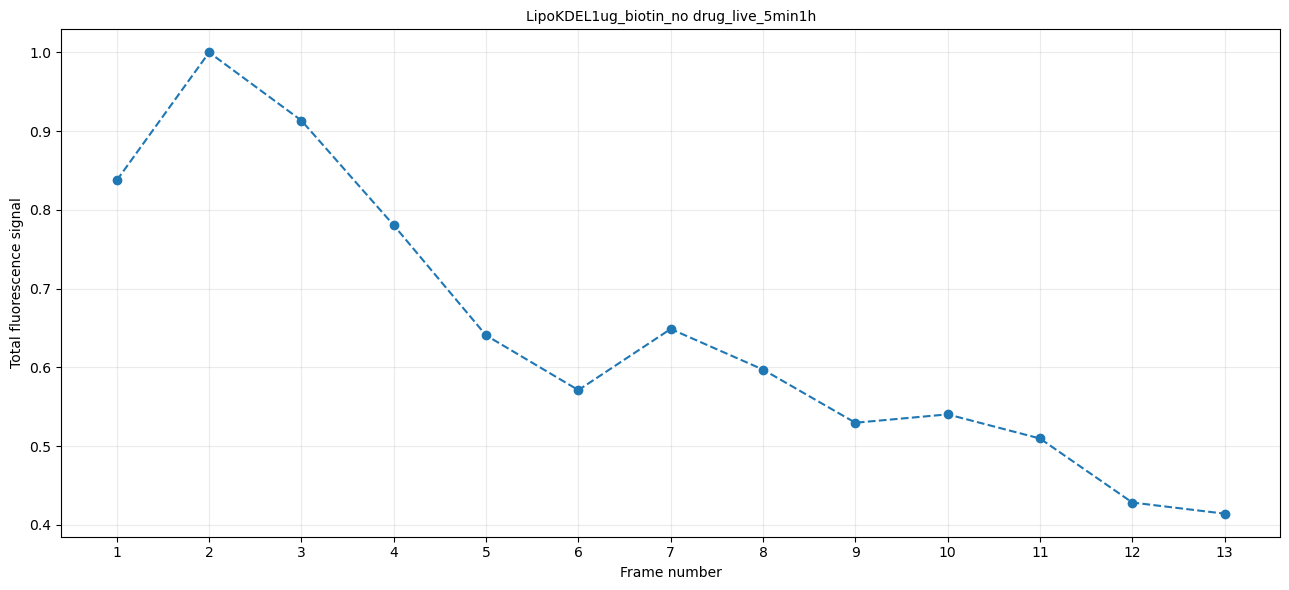

In [51]:
x = range(1,14) #This needs to match the number of total_fluorescence indexes
y = total_fluorescence / max(total_fluorescence) #Normalised to the img with the highest total brightness, as the highest datapoint = 1

#plotting segment
plt.figure(figsize = (13, 6)) #setting the figure size, has to be before plt.plot
plt.plot(x, y, linestyle = 'dashed', marker = 'o') #marker is the data point, marked as circle.

#Labels & aesthetics
plt.xticks(x) #this makes it show every tick in X axis
plt.xlabel('Frame number', fontsize = 10)
plt.ylabel('Total fluorescence signal', fontsize = 10)
plt.grid(alpha = .25)
plt.title('LipoKDEL1ug_biotin_no drug_live_5min1h', fontsize = 10)

plt.tight_layout() #trying out
plt.show()